Epoch 1/20, Loss: 0.00014611873484682292
Epoch 2/20, Loss: 0.006845783907920122
Epoch 3/20, Loss: 0.00019456348672974855
Epoch 4/20, Loss: 0.0007834483403712511
Epoch 5/20, Loss: 0.0002806461416184902
Epoch 6/20, Loss: 0.0005512325442396104
Epoch 7/20, Loss: 0.00020385255629662424
Epoch 8/20, Loss: 2.3776250600349158e-05
Epoch 9/20, Loss: 0.0005041733966208994
Epoch 10/20, Loss: 0.028787516057491302
Epoch 11/20, Loss: 0.0002692330745048821
Epoch 12/20, Loss: 0.010235182009637356
Epoch 13/20, Loss: 3.926730278180912e-05
Epoch 14/20, Loss: 0.00030859222169965506
Epoch 15/20, Loss: 0.001872400869615376
Epoch 16/20, Loss: 0.00027095674886368215
Epoch 17/20, Loss: 0.0070052603259682655
Epoch 18/20, Loss: 0.012007739394903183
Epoch 19/20, Loss: 3.558221214916557e-05
Epoch 20/20, Loss: 3.450871736276895e-05
RMSE: 0.03146187540295854, MAE: 0.01659081121447176


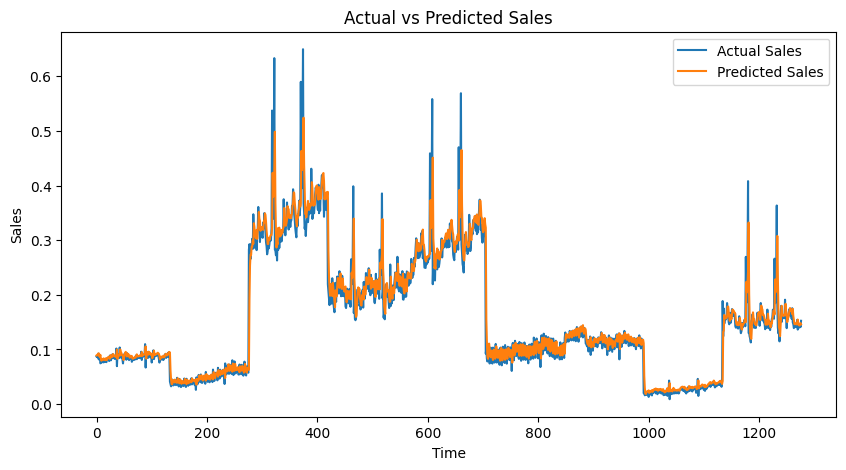

Future Sales Forecast: [[760861.64395185]
 [770436.82603827]
 [780027.49498582]
 [789401.88561574]
 [798909.20513705]
 [808324.1412298 ]
 [817929.00646672]
 [827655.18544919]
 [837633.13347273]
 [848000.83416814]]


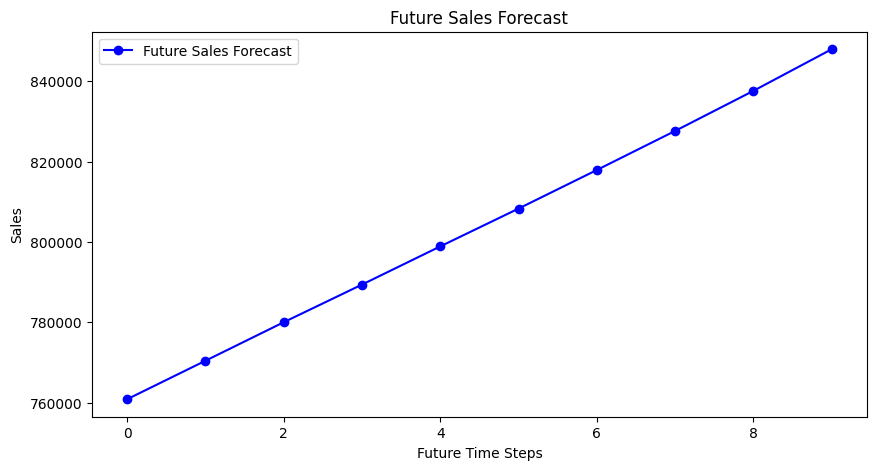

In [37]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader

# Load the dataset
df = pd.read_csv('/content/Walmart DataSet.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)

# Preprocess data
def preprocess_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['Weekly_Sales']])
    return scaled_data, scaler

scaled_data, scaler = preprocess_data(df)

# Split into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create dataset class
class SalesDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx:idx+self.seq_length], dtype=torch.float32),
            torch.tensor(self.data[idx+self.seq_length], dtype=torch.float32)
        )

seq_length = 10
train_dataset = SalesDataset(train_data, seq_length)
test_dataset = SalesDataset(test_data, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define LSTM Model
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, num_layers=2, output_dim=1):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        pred = self.fc(lstm_out[:, -1])
        return pred

# Train model
def train_model(dataloader, model, epochs=20, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for seqs, targets in dataloader:
            optimizer.zero_grad()
            preds = model(seqs)
            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')
    return model

model = LSTMPredictor()
trained_model = train_model(train_dataloader, model)

# Evaluate model
def evaluate_model(model, dataloader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for seqs, targets in dataloader:
            preds = model(seqs).numpy()
            predictions.extend(preds.flatten())
            actuals.extend(targets.numpy().flatten())
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    print(f'RMSE: {rmse}, MAE: {mae}')

    # Plot actual vs predicted values
    plt.figure(figsize=(10,5))
    plt.plot(actuals, label='Actual Sales')
    plt.plot(predictions, label='Predicted Sales')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.legend()
    plt.title('Actual vs Predicted Sales')
    plt.show()

evaluate_model(trained_model, test_dataloader)

# Forecast future sales
def forecast(model, data, future_steps=10):
    model.eval()
    predictions = []
    input_seq = torch.tensor(data[-seq_length:], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        for _ in range(future_steps):
            pred = model(input_seq)
            predictions.append(pred.item())
            input_seq = torch.cat((input_seq[:, 1:, :], pred.unsqueeze(-1)), dim=1)
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

future_sales = forecast(trained_model, scaled_data)
print("Future Sales Forecast:", future_sales)

# Plot Future Forecast
plt.figure(figsize=(10,5))
plt.plot(future_sales, marker='o', linestyle='-', color='b', label='Future Sales Forecast')
plt.xlabel('Future Time Steps')
plt.ylabel('Sales')
plt.title('Future Sales Forecast')
plt.legend()
plt.show()
